In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from mpl_toolkits.mplot3d import Axes3D

In [3]:
class Universe(object):
    ''' Defines the shape which is enough to retain geometric state of any shape.  
        The universe shape is used to convert a shape to a binary state vector.
        
        Also defines the coordinate basis in which the shapes are specified, 
        and color for underlying (unshifted, unrotated) pieces.'''
    def __init__(self,board, basis):
        self.universe=board.grow(1)
        self.universe.idx=-2
        self.basis=basis #useful for 4-way symmetric lattices.

        #a color for each piece index, to match a real-life puzzle piece color
        self.colors=(
            'xkcd:beige',
        )
        
class Shape(object):
    '''A covering set, a.k.a a puzzle piece rotated and translated to cover a specific region of the puzzle.'''
    
    def __init__(self,ar,idx):
        self.ar=ar
        self.idx=idx
    
    def __repr__(self):
        return 'Shape'+str((self.ar, self.idx))
    
    def grow(self, by):
        '''return a piece like self, but grown by 'by' points in either direction along each of u.basis vectors in the lattice.
            FIXME not implemented for trangular or hexagonal lattices.
        '''
        kern=list((product([-1,0,1],repeat=3))) #27 vectors for all the neighbors of a point in 3d grid, including edge and corner neighbors
        kern=np.array(kern,dtype=np.int8)
        grown=(kern+self.ar[:,None,:]) #pairwise add every tuple in kern to every tuple in ar.  See numpy broadcasting for why this works.
        grown=np.vstack(grown)
        return Shape(np.unique(grown,axis=0),self.idx)
    
    
class ShapeSet(set):
    '''A collection of Shapes.'''
    def visualize(self):
        '''draw a set of shapes in 3d'''
        fig = plt.figure()
        fig.set_size_inches(5,5)
        ax = fig.add_subplot(111, projection='3d')
        allShapes=np.vstack([s.ar for s in self])
        allShapes
        X,Y,Z=np.hsplit(allShapes,3)
        #bounding box
        # Create cubic bounding box to simulate equal aspect ratio
        max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
           ax.plot([xb], [yb], [zb], 'w')
        display(len(self))
        for p in self:
            if p.idx >=0 :
                color=u.colors[p.idx]
                size=2000
            elif p.idx==-1:#the board
                color='green'
                size=30
            elif p.idx==-2:#the universe
                color='black'
                size=5
            inEuclidean=p.ar.dot(u.basis.T)
            ax.scatter(*np.hsplit(inEuclidean,3), c=color, marker='o', s=size)
            ax.set_aspect('equal')
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')

        plt.tight_layout()   

In [8]:
#define the pieces of our puzzle.  They are all planar.
pieces=[
  #nightstick
  np.array([
      [0,0],
      [1,0],
      [2,0],
      [3,0],
      [1,1]
    ]),
]
for i,p in enumerate(pieces):
    withZaxis=np.append(p,np.zeros((p.shape[0],1),dtype=np.int8),axis=1)
    pieces[i]=Shape(withZaxis, i)

pieces

[Shape(array([[0, 0, 0],
        [1, 0, 0],
        [2, 0, 0],
        [3, 0, 0],
        [1, 1, 0]]), 0)]

In [9]:
#our board is a pyramid with a 5x5 base, but in our basis, 
#one ridge of the pyramid is along the z-axis
side=5
board=np.zeros((side,side,side),dtype=np.int8)
for z in range(side): 
    board[z,:side-z,:side-z]=1
board=np.transpose(np.flip(np.nonzero(board),0))    
# board=np.array([[0,0,0],
#                 [0,0,1]
#                ])
board=Shape(board,-1)

In [ ]:
#many Shape and ShapeSet methods (those making use of a Shape's state representation) require the universe u global variable defined
basis=np.array([[1,0,0.5],
                [0,1,0.5],
                [0,0,2.0**.5/2]])
# basis=np.eye(3)
u=Universe(board,basis)

## Rotation of shapes on a lattice.

This is the part that I understand the least about solving the puzzle, but I will write down what I know.

If a rotation $M$ is an isomorphism of the lattice, it is a valid rotation for a shape (FIXME: It feels like it's also necessary for $M$ to be a lattice isomorphism, but I haven't proved it yet).

### Which orientations are valid?
Our piece can 'point' from the origin along the axes in the $X-Y$ plane, and also along the 8 diagnonals in the directions of 
$$
\begin{bmatrix}
         \pm 1\\
         \pm 1\\
         \pm 1\\
\end{bmatrix}
$$
For each direction, the piece can also be rotated around it's pointing direction by $180^{\circ}$ and still remain on the lattice.
So we have 24 possible orientations.   It **looks** like that's it, but I have no proof.  Our lattice looks like a [Monoclinic crystal system with a Oblique rhombic prism
unit cell](https://en.wikipedia.org/wiki/Monoclinic_crystal_system), and there are some references to groups which may explain more.

It looks like all orientations can be generated by rotating the piece by $90^{\circ}$ 0,1,2 or 3 times about the diagnoals in the $X-Y$ plane, and permuting the axes of rotation:
So 
1. Pick an axis of rotation from 
$$
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         \frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
,
\begin{bmatrix}
         \frac{\sqrt{2}}{2}\\
         -\frac{\sqrt{2}}{2}\\
         0\\
\end{bmatrix}
$$
and rotate about it by a multiple of $90^{\circ}$
2. Take the remaining axis and rotate the piece from step 1 about it by a multiple of $90^{\circ}$.

The above gives 32 rotations, so some of the 24 valid orientations will be created twice.

Any advice from an abstract algebraist or a crystallographer or a solidchemist


(1485, 3)


<IPython.core.display.Javascript object>


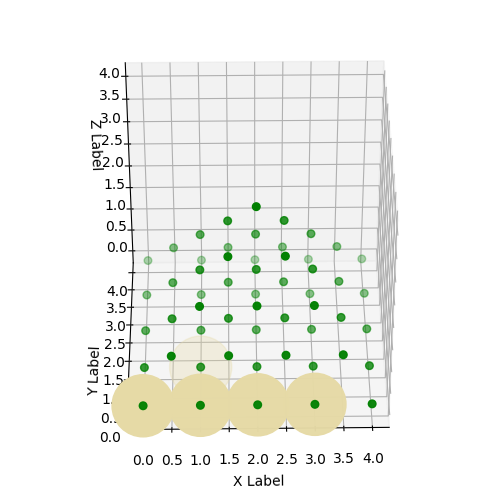

2

In [11]:
s=ShapeSet([ board, pieces[0]])
s.visualize()